### Main imports

In [1]:
import os
import requests
from tqdm import tqdm
import zipfile
import numpy as np
import torch
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display as disp
from pathlib import Path

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device.type)
print('Imports complete.')

Device: cuda
Imports complete.


### Import dataset

In [3]:
import os
import numpy
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# directory where the data is stored
data_dir = 'classification-data'

# the .npy files
train_x_path = os.path.join(data_dir, 'train_x.npy')
train_y_path = os.path.join(data_dir, 'train_y.npy')
valid_x_path = os.path.join(data_dir, 'valid_x.npy')
valid_y_path = os.path.join(data_dir, 'valid_y.npy')
test_x_path = os.path.join(data_dir, 'test_x.npy')
test_y_path = os.path.join(data_dir, 'test_y.npy')

# load the data
print("Loading data...")
train_x = numpy.load(train_x_path)
train_y = numpy.load(train_y_path)
valid_x = numpy.load(valid_x_path)
valid_y = numpy.load(valid_y_path)
test_x = numpy.load(test_x_path)
test_y = numpy.load(test_y_path)
print("Data loaded successfully.")

print("Shape of one training sample:", train_x.shape[1:])
print("Shape of one validation sample:", valid_x.shape[1:])
print("Shape of one test sample:", test_x.shape[1:])

train_x = train_x.reshape(-1, 3, 28, 28) 
valid_x = valid_x.reshape(-1, 3, 28, 28) 
test_x = test_x.reshape(-1, 3, 28, 28)

print("Shape of one training sample:", train_x.shape[1:])
print("Shape of one validation sample:", valid_x.shape[1:])
print("Shape of one test sample:", test_x.shape[1:])

# convert NumPy arrays to PyTorch tensors - HAS BEEN CHANGED FOR THE ABOVE
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()
valid_x = torch.from_numpy(valid_x).float()

valid_y = torch.from_numpy(valid_y).long()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

# create TensorDataset instances
train_dataset = TensorDataset(train_x, train_y)
valid_dataset = TensorDataset(valid_x, valid_y)
test_dataset = TensorDataset(test_x, test_y)

# batch size
batch_size = 64

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Helper function to cycle through the data indefinitely
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# iterators for training, validation, and test loaders
train_iterator = iter(cycle(train_loader))
valid_iterator = iter(cycle(valid_loader))
test_iterator = iter(cycle(test_loader))

# class names
class_names = [str(i) for i in range(20)]

# dataset sizes
print(f'> Size of training dataset: {len(train_dataset)}')
print(f'> Size of validation dataset: {len(valid_dataset)}')
print(f'> Size of test dataset: {len(test_dataset)}')

num_batches_per_epoch = len(train_loader) // batch_size

num_of_epochs = 50000 // num_batches_per_epoch

print(f'Number of batches per epoch: {num_batches_per_epoch}')
print(f'Number of epochs: {num_of_epochs}')


Loading data...
Data loaded successfully.
Shape of one training sample: (3, 28, 28)
Shape of one validation sample: (3, 28, 28)
Shape of one test sample: (3, 28, 28)
Shape of one training sample: (3, 28, 28)
Shape of one validation sample: (3, 28, 28)
Shape of one test sample: (3, 28, 28)
> Size of training dataset: 45000
> Size of validation dataset: 15000
> Size of test dataset: 10000
Number of batches per epoch: 10
Number of epochs: 5000


**View some of the test dataset**

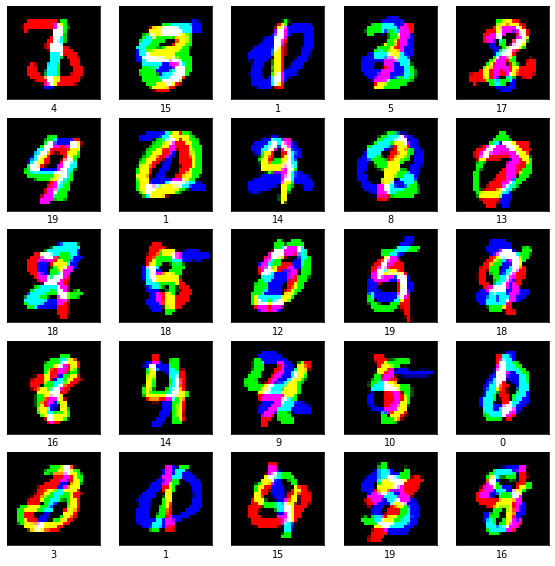

In [4]:
plt.rcParams['figure.dpi'] = 70
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = test_loader.dataset[i][0].numpy().transpose(1, 2, 0)
    img = numpy.clip(img, 0, 1)
    plt.imshow(img)
    plt.xlabel(class_names[test_loader.dataset[i][1]])
plt.show()

### Resnet Model

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection for dimensionality match
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        out += self.shortcut(residual)
        out = F.relu(out)
        
        return out

class ResNet32x32(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet32x32, self).__init__()
        
        # Initial layer - smaller kernel and no stride for 32x32 images
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Residual layers
        self.layer1 = self._make_layer(64, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        
        # Final classification layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution
        out = F.relu(self.bn1(self.conv1(x)))
        
        # Residual blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # Classification
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

def create_model(num_classes=100, device='cuda'):
    model = ResNet32x32(num_classes=num_classes)
    model = model.to(device)
    
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    return model, optimizer, criterion

model, optimizer, criterion = create_model(num_classes=100, device=device)

print("Parameter count:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Parameter count: 2800804


### Main training and testing loop - Attempt 1

Epoch [1/5000], Batch [1/703], Loss: 4.8314, Accuracy: 0.00%
Epoch [1/5000], Batch [2/703], Loss: 4.6101, Accuracy: 0.00%
Epoch [1/5000], Batch [3/703], Loss: 4.3658, Accuracy: 4.17%
Epoch [1/5000], Batch [4/703], Loss: 4.2270, Accuracy: 5.86%
Epoch [1/5000], Batch [5/703], Loss: 4.0772, Accuracy: 6.25%
Epoch [1/5000], Batch [6/703], Loss: 3.9709, Accuracy: 5.99%
Epoch [1/5000], Batch [7/703], Loss: 3.8663, Accuracy: 6.47%
Epoch [1/5000], Batch [8/703], Loss: 3.7764, Accuracy: 7.62%
Epoch [1/5000], Batch [9/703], Loss: 3.6993, Accuracy: 7.47%
Epoch [1/5000], Batch [10/703], Loss: 3.6336, Accuracy: 7.34%
Epoch [1/5000], Batch [11/703], Loss: 3.5716, Accuracy: 7.67%
Epoch [1/5000], Batch [12/703], Loss: 3.5237, Accuracy: 7.68%
Epoch [1/5000], Batch [13/703], Loss: 3.4882, Accuracy: 7.57%
Epoch [1/5000], Batch [14/703], Loss: 3.4497, Accuracy: 7.59%
Epoch [1/5000], Batch [15/703], Loss: 3.4113, Accuracy: 7.50%
Epoch [1/5000], Batch [16/703], Loss: 3.3828, Accuracy: 7.81%
Epoch [1/5000], B

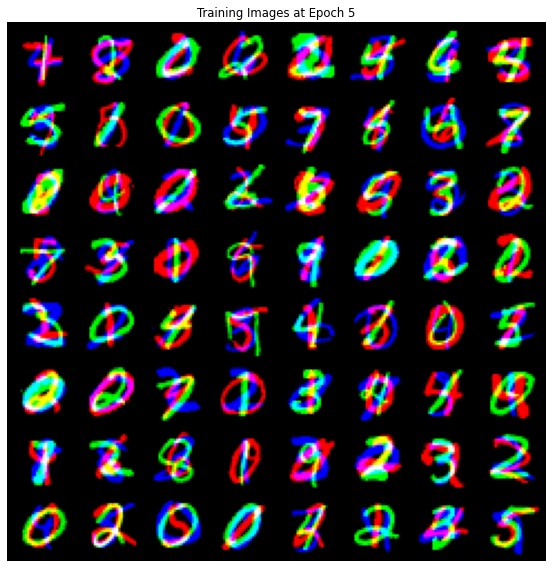

Epoch 4 finished!
Epoch [6/5000], Batch [1/703], Loss: 0.1945, Accuracy: 95.31%
Epoch [6/5000], Batch [2/703], Loss: 0.2712, Accuracy: 92.97%
Epoch [6/5000], Batch [3/703], Loss: 0.3425, Accuracy: 88.54%
Epoch [6/5000], Batch [4/703], Loss: 0.3650, Accuracy: 88.67%
Epoch [6/5000], Batch [5/703], Loss: 0.3550, Accuracy: 88.75%
Epoch [6/5000], Batch [6/703], Loss: 0.3391, Accuracy: 89.84%
Epoch [6/5000], Batch [7/703], Loss: 0.3575, Accuracy: 89.73%
Epoch [6/5000], Batch [8/703], Loss: 0.3463, Accuracy: 90.23%
Epoch [6/5000], Batch [9/703], Loss: 0.3610, Accuracy: 90.10%
Epoch [6/5000], Batch [10/703], Loss: 0.3723, Accuracy: 89.22%
Epoch [6/5000], Batch [11/703], Loss: 0.3726, Accuracy: 89.49%
Epoch [6/5000], Batch [12/703], Loss: 0.3730, Accuracy: 89.32%
Epoch [6/5000], Batch [13/703], Loss: 0.3840, Accuracy: 88.94%
Epoch [6/5000], Batch [14/703], Loss: 0.3896, Accuracy: 88.95%
Epoch [6/5000], Batch [15/703], Loss: 0.3830, Accuracy: 88.96%
Epoch [6/5000], Batch [16/703], Loss: 0.3857, 

In [ ]:
save_dir = Path('checkpoints')
save_dir.mkdir(exist_ok=True)
best_acc = 0.0
epoch = 0
batch_size = train_loader.batch_size
check_interval = 5

# training loop
while (epoch < num_of_epochs):
    model.train()
    
    # arrays for metrics
    logs = {}
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    
    # iterate over the train dataset
    for i, batch in enumerate(train_loader):
        x, t = batch
        x, t = x.to(device), t.to(device)
        
        # forward pass
        outputs = model(x)
        loss = criterion(outputs, t)
        
        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # calculate accuracy
        _, predicted = outputs.max(1)
        accuracy = predicted.eq(t).sum().item() / t.size(0) * 100
        
        # store metrics
        train_loss_arr = np.append(train_loss_arr, loss.item())
        train_acc_arr = np.append(train_acc_arr, accuracy)
        
        print(f'Epoch [{epoch+1}/{num_of_epochs}], Batch [{i+1}/{len(train_loader)}], '
                f'Loss: {train_loss_arr.mean():.4f}, Accuracy: {train_acc_arr.mean():.2f}%')
    
    # validation check at specified intervals
    if (epoch + 1) % check_interval == 0:
        model.eval()
        val_loss_arr = np.zeros(0)
        val_acc_arr = np.zeros(0)
        
        with torch.no_grad():
            for val_x, val_t in test_loader: # this might be incorrect for the loop
                val_x, val_t = val_x.to(device), val_t.to(device)
                val_outputs = model(val_x)
                val_loss = criterion(val_outputs, val_t)
                
                _, val_predicted = val_outputs.max(1)
                val_accuracy = val_predicted.eq(val_t).sum().item() / val_t.size(0) * 100
                
                val_loss_arr = np.append(val_loss_arr, val_loss.item())
                val_acc_arr = np.append(val_acc_arr, val_accuracy)
            
            print(f'\nValidation at Epoch [{epoch+1}/{num_of_epochs}], '
                    f'Loss: {val_loss_arr.mean():.4f}, Accuracy: {val_acc_arr.mean():.2f}%')
            
            # save best model
            if val_acc_arr.mean() > best_acc:
                best_acc = val_acc_arr.mean()
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'accuracy': best_acc,
                }
                torch.save(checkpoint, save_dir / 'best_model.pth')
                print(f'New best validation accuracy: {best_acc:.2f}%')
            
            # visualize random batch of training images
            plt.figure(figsize=(10, 10))
            plt.axis('off')
            plt.title(f'Training Images at Epoch {epoch+1}')
            plt.imshow(np.transpose(
                torchvision.utils.make_grid(x[:batch_size], padding=2, normalize=True).cpu(),
                (1, 2, 0)
            ))
            plt.show()
        
        model.train()
    
    print(f"Epoch {epoch} finished!")
    epoch += 1

print('\nTraining completed!')
print(f'Best validation accuracy: {best_acc:.2f}%')

## Inference on data

This is useful for analysis but is entirely optional

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    img = numpy.clip(img, 0, 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = numpy.transpose(img, (1, 2, 0))
    plt.imshow(img)

    predicted_label = numpy.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*numpy.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(20), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = numpy.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images), dim=1).data.cpu().numpy()
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu().numpy(), test_images.cpu().numpy()) # Used .numpy() here
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels.cpu().numpy())